In [1]:
!pip install -q kaggle

Acesse https://www.kaggle.com/ e crie sua conta. Entre nas configurações da sua conta e clique em **Create New Token**. Faça o upload do arquivo usando o código abaixo.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"otaviocozer","key":"a0d0b6bb92ca10ebd24e1371edf6d7ab"}'}

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!mkdir inference

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lgmoneda/br-coins

100% 942M/945M [00:48<00:00, 21.3MB/s]
100% 945M/945M [00:48<00:00, 20.6MB/s]


In [5]:
!unzip /content/br-coins.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: regression_dataset/all/125_1479424848.jpg  
  inflating: regression_dataset/all/130_1477861908.jpg  
  inflating: regression_dataset/all/130_1477861914.jpg  
  inflating: regression_dataset/all/130_1477861920.jpg  
  inflating: regression_dataset/all/130_1477861926.jpg  
  inflating: regression_dataset/all/130_1477861932.jpg  
  inflating: regression_dataset/all/130_1477861938.jpg  
  inflating: regression_dataset/all/130_1477861944.jpg  
  inflating: regression_dataset/all/130_1477861950.jpg  
  inflating: regression_dataset/all/130_1477861956.jpg  
  inflating: regression_dataset/all/130_1477861962.jpg  
  inflating: regression_dataset/all/130_1477861968.jpg  
  inflating: regression_dataset/all/130_1477861974.jpg  
  inflating: regression_dataset/all/130_1477861980.jpg  
  inflating: regression_dataset/all/130_1477861986.jpg  
  inflating: regression_dataset/all/130_1477861992.jpg  
  inflating: regression_datas

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import glob as glob
import os

import cv2
from google.colab.patches import cv2_imshow

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

BATCH_SIZE = 8 # increase / decrease according to GPU memeory
RESIZE_TO = 480 # resize the image for training and transforms
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 2

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

IMAGES_DIR = 'COCO_labelme_regression/regression'

IMAGE_PATHS = glob.glob(f"{IMAGES_DIR}/*.jpg")
ALL_IMAGES = [image_path.split(os.path.sep)[-1] for image_path in IMAGE_PATHS]

CLASSES = ['__background__', '5', '10', '25', '50', '100']

NUM_CLASSES = len(CLASSES)

VISUALIZE_TRANSFORMED_IMAGES = True

# SUBSTITUA PELA PASTA NO SEU DRIVE AONDE DESEJA SALVAR SEU MODELO E OS GRÁFICOS DE LOSS
OUT_DIR = "/content/gdrive/MyDrive/PG/Lab4"

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [8]:
class Averager:
  def __init__(self):
    self.current_total = 0.0
    self.iterations = 0.0

  def send(self, value):
    self.current_total += value
    self.iterations += 1

  @property
  def value(self):
    if self.iterations == 0:
        return 0
    else:
        return 1.0 * self.current_total / self.iterations

  def reset(self):
    self.current_total = 0.0
    self.iterations = 0.0

class SaveBestModel:
  def __init__(self, best_valid_loss=float('inf')):
    self.best_valid_loss = best_valid_loss

  def __call__(self, current_valid_loss, epoch, model, optimizer, dir, name):
    if current_valid_loss < self.best_valid_loss:
      self.best_valid_loss = current_valid_loss
      print(f"\nBest validation loss: {self.best_valid_loss}")
      print(f"\nSaving best model for epoch: {epoch+1}\n")
      torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),}, f'{dir}/{name}.pth')

def collate_fn(batch):
  return tuple(zip(*batch))


In [9]:
class CustomDataset(Dataset):
  def __init__(self, dir_path, width, height, classes, all_images):
    self.dir_path = dir_path
    self.width = width
    self.height = height
    self.classes = classes
    self.all_images = all_images

  def __getitem__(self, idx):
    image_name = self.all_images[idx]
    image_path = os.path.join(self.dir_path, image_name)

    image = cv2.imread(image_path)
    image_resized = cv2.resize(image.astype(np.float32), (self.width, self.height))
    image_resized /= 255.0

    boxes = []
    labels = []

    annot_filename = image_name[:-4] + '.json'
    annot_file_path = os.path.join(self.dir_path, annot_filename)
    with open(annot_file_path) as my_file:
      annot_boxes = json.loads(my_file.read())

    image_width = image.shape[1]
    image_height = image.shape[0]

    for shape in annot_boxes["shapes"]:
      if shape["label"] == "finger":
        continue

      if shape["shape_type"] == "polygon":
        x, y = shape["points"][0]
        xmin, ymin, xmax, ymax,  = int(x), int(y), int(x), int(y)
        for x, y in shape["points"]:
          x, y = int(x), int(y)
          xmin = min(xmin, x)
          ymin = min(ymin, y)
          xmax = max(xmax, x)
          ymax = max(ymax, y)

      else:
        xc = int(shape["points"][0][0])
        yc = int(shape["points"][0][1])
        xe = int(shape["points"][1][0])
        ye = int(shape["points"][1][1])
        radius = ((xc - xe)**2 + (yc - ye)**2)**0.5

        xmin = xc - radius
        xmax = xc + radius
        ymin = yc - radius
        ymax = yc + radius

      labels.append(self.classes.index(shape["label"]))

      xmin_final = (xmin/image_width)*self.width
      xmax_final = (xmax/image_width)*self.width
      ymin_final = (ymin/image_height)*self.height
      yamx_final = (ymax/image_height)*self.height

      xmin_final = 0 if xmin_final <= 0 else xmin_final
      xmax_final = self.width if xmax_final >= self.width else xmax_final
      ymin_final = 0 if ymin_final <= 0 else ymin_final
      yamx_final = self.height if yamx_final >= self.height else yamx_final

      boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])

    target = {}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

    image_resized = torch.tensor(image_resized).permute(2, 0, 1)
    return image_resized, target

  def __len__(self):
    return len(self.all_images)

def create_train_dataset():
  train_dataset = CustomDataset(IMAGES_DIR, RESIZE_TO, RESIZE_TO, CLASSES, TRAIN_IMAGES)
  return train_dataset
def create_valid_dataset():
  valid_dataset = CustomDataset(IMAGES_DIR, RESIZE_TO, RESIZE_TO, CLASSES, VALIDATION_IMAGES)
  return valid_dataset

def create_train_loader(train_dataset, num_workers=0):
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
  return train_loader
def create_valid_loader(valid_dataset, num_workers=0):
  valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
  return valid_loader

Number of training images: 9


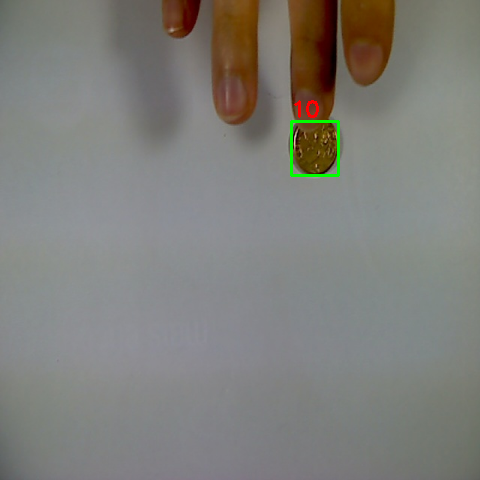

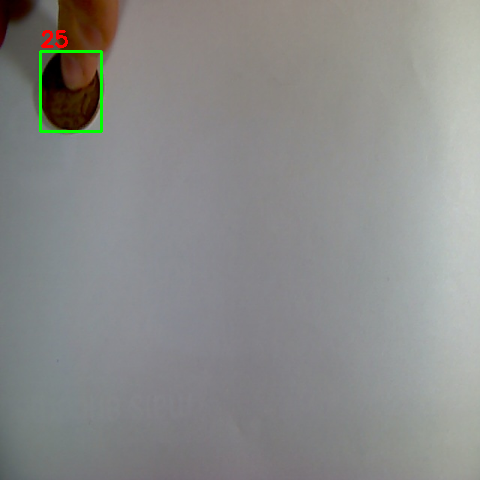

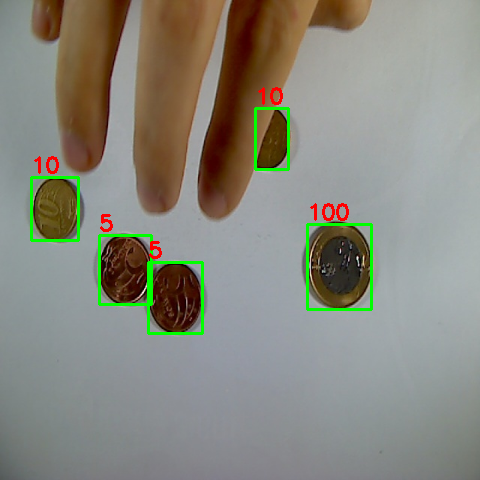

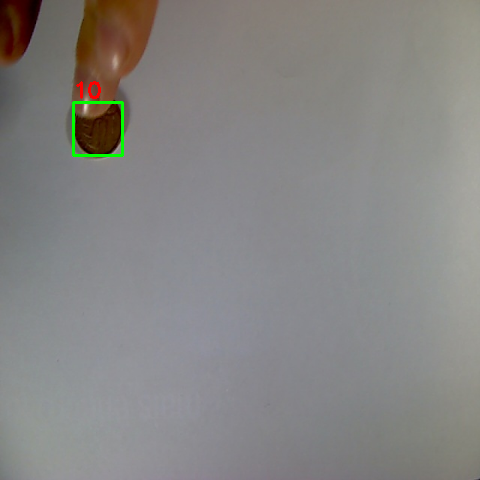

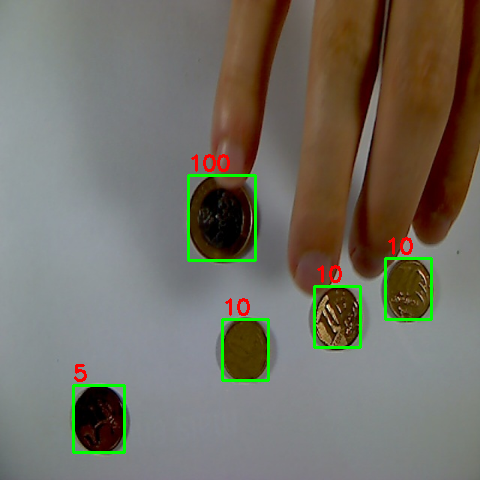

In [10]:
IMAGES = ["10_1477289016.jpg", "25_1477149534.jpg", "130_1477862364.jpg",
          "10_1477186224.jpg", "135_1479426018.jpg", "100_1477195278.jpg",
          "75_1477849572.jpg", "100_1477195260.jpg", "5_1477145532.jpg"]
dataset = CustomDataset(IMAGES_DIR, RESIZE_TO, RESIZE_TO, CLASSES, IMAGES)
print(f"Number of training images: {len(dataset)}")

for i in range(5):
  image, target = dataset[i]
  image = image.permute(1, 2, 0).data.numpy() * 255.0
  for box_num in range(len(target['boxes'])):
    box = target['boxes'][box_num]
    label = CLASSES[target['labels'][box_num]]
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(0, 255, 0), 2)
    cv2.putText(image, label, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

  cv2_imshow(image)

In [11]:
def train(train_data_loader, model):
  print('Training')
  global train_itr
  global train_loss_list

  prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

  for i, data in enumerate(prog_bar):
    optimizer.zero_grad()
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    train_loss_list.append(loss_value)

    train_loss_avg.send(loss_value)

    losses.backward()
    optimizer.step()

    train_itr += 1

    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")


def validate(valid_data_loader, model):
  print('Validating')
  global val_itr
  global val_loss_list

  prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

  for i, data in enumerate(prog_bar):
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    with torch.no_grad():
      loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    val_loss_list.append(loss_value)

    val_loss_avg.send(loss_value)

    val_itr += 1

    prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

In [ ]:
TRAIN_IMAGES, VALIDATION_IMAGES, _ = torch.utils.data.random_split(ALL_IMAGES, [0.008, 0.002, 0.99])
TRAIN_IMAGES, VALIDATION_IMAGES = sorted(TRAIN_IMAGES), sorted(VALIDATION_IMAGES)

Number of training samples: 49
Number of validation samples: 12



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 92.8MB/s]



EPOCH 1 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #1 train loss: 1.481
Epoch #1 validation loss: 1.403
Took 0.297 minutes for epoch 1

Best validation loss: 1.403036653995514

Saving best model for epoch: 1


EPOCH 2 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #2 train loss: 1.002
Epoch #2 validation loss: 1.075
Took 0.179 minutes for epoch 2

Best validation loss: 1.0745261907577515

Saving best model for epoch: 2


EPOCH 3 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #3 train loss: 0.828
Epoch #3 validation loss: 0.950
Took 0.184 minutes for epoch 3

Best validation loss: 0.9504967331886292

Saving best model for epoch: 3


EPOCH 4 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #4 train loss: 0.856
Epoch #4 validation loss: 0.839
Took 0.184 minutes for epoch 4

Best validation loss: 0.8394204378128052

Saving best model for epoch: 4


EPOCH 5 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #5 train loss: 0.728
Epoch #5 validation loss: 0.692
Took 0.184 minutes for epoch 5

Best validation loss: 0.6918231248855591

Saving best model for epoch: 5


EPOCH 6 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #6 train loss: 0.608
Epoch #6 validation loss: 0.619
Took 0.186 minutes for epoch 6

Best validation loss: 0.6194247305393219

Saving best model for epoch: 6


EPOCH 7 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #7 train loss: 0.618
Epoch #7 validation loss: 0.590
Took 0.190 minutes for epoch 7

Best validation loss: 0.5899280905723572

Saving best model for epoch: 7


EPOCH 8 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #8 train loss: 0.570
Epoch #8 validation loss: 0.531
Took 0.195 minutes for epoch 8

Best validation loss: 0.5313475728034973

Saving best model for epoch: 8


EPOCH 9 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #9 train loss: 0.501
Epoch #9 validation loss: 0.489
Took 0.188 minutes for epoch 9

Best validation loss: 0.4886006712913513

Saving best model for epoch: 9


EPOCH 10 of 10
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch #10 train loss: 0.460
Epoch #10 validation loss: 0.450
Took 0.193 minutes for epoch 10

Best validation loss: 0.44974978268146515

Saving best model for epoch: 10

SAVING PLOTS COMPLETE...


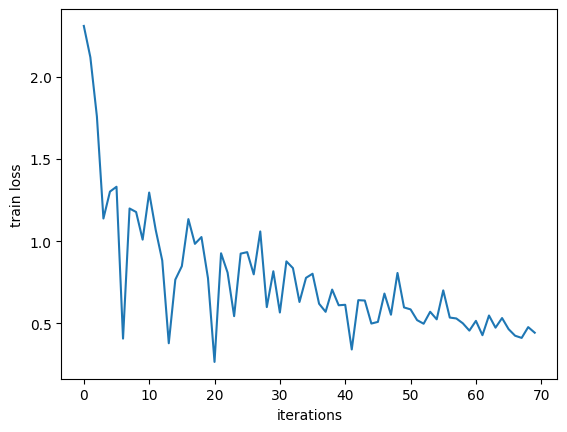

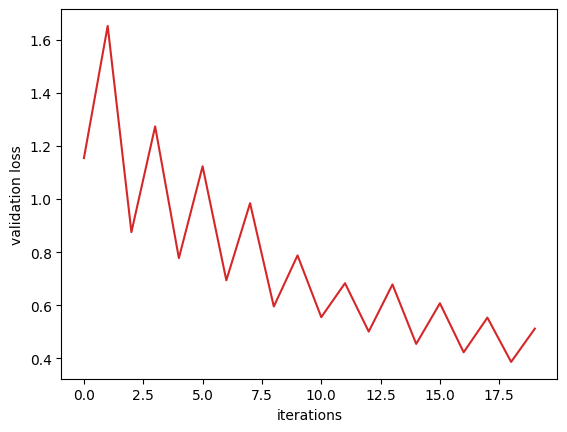

In [ ]:
train_dataset = create_train_dataset()
valid_dataset = create_valid_dataset()
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

train_loss_avg = Averager()
val_loss_avg = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

save_best_model = SaveBestModel()

model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

for epoch in range(NUM_EPOCHS):
  print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

  train_loss_avg.reset()
  val_loss_avg.reset()

  start = time.time()
  train(train_loader, model)
  validate(valid_loader, model)
  print(f"Epoch #{epoch+1} train loss: {train_loss_avg.value:.3f}")
  print(f"Epoch #{epoch+1} validation loss: {val_loss_avg.value:.3f}")
  end = time.time()
  print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

  save_best_model(val_loss_avg.value, epoch, model, optimizer, OUT_DIR, "last_model")

  torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), }, f'{OUT_DIR}/last_model.pth')

figure_1, train_ax = plt.subplots()
figure_2, valid_ax = plt.subplots()
train_ax.plot(train_loss_list, color='tab:blue')
train_ax.set_xlabel('iterations')
train_ax.set_ylabel('train loss')
valid_ax.plot(val_loss_list, color='tab:red')
valid_ax.set_xlabel('iterations')
valid_ax.set_ylabel('validation loss')
figure_1.savefig(f"{OUT_DIR}/train_loss.png")
figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
print('SAVING PLOTS COMPLETE...')



In [12]:
model = create_model(num_classes=NUM_CLASSES)
best_model = torch.load(f'{OUT_DIR}/best_model_solution.pth', map_location=DEVICE)
model.load_state_dict(best_model['model_state_dict'])
model.to(DEVICE).eval()

print(f"Test instances: {len(ALL_IMAGES)}")

detection_threshold = 0.8

for i in range(len(ALL_IMAGES)):
  # get the image file name for saving output later on
  image_name = ALL_IMAGES[i]
  image_path = os.path.join(IMAGES_DIR, image_name)
  image = cv2.imread(image_path)
  orig_image = image.copy()
  image = image.astype(np.float32) / 255.0

  image = np.transpose(image, (2, 0, 1)).astype(np.float32)
  image = torch.tensor(image, dtype=torch.float).cuda()
  image = torch.unsqueeze(image, 0)

  with torch.no_grad():
    outputs = model(image.to(DEVICE))

  outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

  if len(outputs[0]['boxes']) != 0:

    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()

    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()

    pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

    for j, box in enumerate(draw_boxes):
      class_name = pred_classes[j]
      cv2.rectangle(orig_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(0, 255, 0), 2)
      cv2.putText(orig_image, class_name, (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, lineType=cv2.LINE_AA)

    cv2.imwrite(f"inference/{image_name}", orig_image)
  print(f"Image {i+1} done...")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 50.5MB/s]


A saída de streaming foi truncada nas últimas 5000 linhas.
Image 1022 done...
Image 1023 done...
Image 1024 done...
Image 1025 done...
Image 1026 done...
Image 1027 done...
Image 1028 done...
Image 1029 done...
Image 1030 done...
Image 1031 done...
Image 1032 done...
Image 1033 done...
Image 1034 done...
Image 1035 done...
Image 1036 done...
Image 1037 done...
Image 1038 done...
Image 1039 done...
Image 1040 done...
Image 1041 done...
Image 1042 done...
Image 1043 done...
Image 1044 done...
Image 1045 done...
Image 1046 done...
Image 1047 done...
Image 1048 done...
Image 1049 done...
Image 1050 done...
Image 1051 done...
Image 1052 done...
Image 1053 done...
Image 1054 done...
Image 1055 done...
Image 1056 done...
Image 1057 done...
Image 1058 done...
Image 1059 done...
Image 1060 done...
Image 1061 done...
Image 1062 done...
Image 1063 done...
Image 1064 done...
Image 1065 done...
Image 1066 done...
Image 1067 done...
Image 1068 done...
Image 1069 done...
Image 1070 done...
Image 1071